In [2]:
import pandas as pd

#Limpieza
import unicodedata
import re
import nltk
from nltk.corpus import stopwords

#Lematización
import spacy

#Stemming
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import word2vec as w2v
import numpy as np

import os

#D2V
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
# Descarga de recursos para NLTK
#nltk.download('punkt')

## Carga de datos

In [3]:
df = pd.read_csv("bible_full.csv")

In [4]:
df.head()

,Libro,Capitulo,Versiculo,Texto
0,genesis,1,1,En el principio creó Dios los cielos y la tierra.
1,genesis,1,2,"Y la tierra estaba desordenada y vacía, y las ..."
2,genesis,1,3,Y dijo Dios: Sea la luz; y fue la luz.
3,genesis,1,4,Y vio Dios que la luz era buena; y separó Dios...
4,genesis,1,5,"Y llamó Dios a la luz Día, y a las tinieblas l..."


In [5]:
sl = df[df['Libro'] == 'salmos']
sl

,Libro,Capitulo,Versiculo,Texto
13940,salmos,1,1,Bienaventurado el varón que no anduvo en conse...
13941,salmos,1,2,"Sino que en la ley de Jehová está su delicia, ..."
13942,salmos,1,3,Será como árbol plantado junto a corrientes de...
13943,salmos,1,4,"No así los malos, Que son como el tamo que arr..."
13944,salmos,1,5,"Por tanto, no se levantarán los malos en el ju..."
...,...,...,...,...
16396,salmos,150,2,Alabadle por sus proezas; Alabadle conforme a ...
16397,salmos,150,3,Alabadle a son de bocina; Alabadle con salteri...
16398,salmos,150,4,Alabadle con pandero y danza; Alabadle con cue...
16399,salmos,150,5,Alabadle con címbalos resonantes; Alabadle con...


In [6]:
df_grouped = sl.groupby(['Libro', 'Capitulo'])['Texto'].apply(' '.join).reset_index()
df_grouped

,Libro,Capitulo,Texto
0,salmos,1,Bienaventurado el varón que no anduvo en conse...
1,salmos,2,"¿Por qué se amotinan las gentes, Y los pueblos..."
2,salmos,3,"¡Oh Jehová, cuánto se han multiplicado mis adv..."
3,salmos,4,"Respóndeme cuando clamo, oh Dios de mi justici..."
4,salmos,5,"Escucha, oh Jehová, mis palabras; Considera mi..."
...,...,...,...
145,salmos,146,"Alaba, oh alma mía, a Jehová. Alabaré a Jehová..."
146,salmos,147,"Alabad a JAH, Porque es bueno cantar salmos a ..."
147,salmos,148,Alabad a Jehová desde los cielos; Alabadle en ...
148,salmos,149,Cantad a Jehová cántico nuevo; Su alabanza sea...


# Preprocesamiento

## Limpieza básica (stopwords y minusculas)

In [7]:
nltk.download('stopwords')
stopwords.words("spanish")[:10] # <-- import the spanish stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cuent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [8]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str) #Descompone en base y marca de combinación
    #Elimina marcas de combinación "unicodedata.combining(c)", pero deja las que esten en la lista aceptada
    only_ascii = "".join([c for c in nfkd_form if not unicodedata.combining(c) or c in ['ñ']])
    return only_ascii

In [9]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing accents but keep the vowel
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    #to lower
    text = text.lower()
    # remove special chars, numbers and accents
    text = remove_accents(text)
    text = re.sub("[^a-z]+", " ", text)
    
    
    # 1. tokenize
    tokens = text.split()
    
    # remove stopwords
    if remove_stopwords:
        # 2. check if stopword
        tokens = [w for w in tokens if not w in stopwords.words("spanish")]
        
    # 3. join back together
    text = " ".join(tokens)
        
    # return text in lower case and stripped of whitespaces
    text = text.strip()
    return text

In [10]:
df_grouped['Texto_SN_stopwords'] = df_grouped['Texto'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df_grouped['Texto_minus'] = df_grouped['Texto'].apply(lambda x: preprocess_text(x, remove_stopwords=False))

## Lematización

In [11]:
nlp = spacy.load("es_core_news_sm")

In [12]:
def lematizar_texto(texto):
    doc = nlp(texto)
    return " ".join([token.lemma_ for token in doc])

In [13]:
df_grouped['Texto_lematizado'] = df_grouped['Texto_minus'].apply(lematizar_texto)

## Stemming

In [14]:
def aplicar_stemming(texto):
    stemmer = SnowballStemmer('spanish')
    palabras = texto.split()
    return " ".join([stemmer.stem(palabra) for palabra in palabras])

In [15]:
df_grouped['Texto_stemming'] = df_grouped['Texto_minus'].apply(aplicar_stemming)

## Resultados

In [16]:
df_grouped

,Libro,Capitulo,Texto,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
0,salmos,1,Bienaventurado el varón que no anduvo en conse...,bienaventurado varon anduvo consejo malos cami...,bienaventurado el varon que no anduvo en conse...,bienaventurado el var que no andar en consejo ...,bienaventur el varon que no anduv en consej de...
1,salmos,2,"¿Por qué se amotinan las gentes, Y los pueblos...",amotinan gentes pueblos piensan cosas vanas le...,por que se amotinan las gentes y los pueblos p...,por que él amotinar el gente y el pueblo pensa...,por que se amotin las gent y los puebl piens c...
2,salmos,3,"¡Oh Jehová, cuánto se han multiplicado mis adv...",oh jehova cuanto multiplicado adversarios leva...,oh jehova cuanto se han multiplicado mis adver...,oh jehova cuanto él haber multiplicar mi adver...,oh jehov cuant se han multiplic mis adversari ...
3,salmos,4,"Respóndeme cuando clamo, oh Dios de mi justici...",respondeme clamo oh dios justicia angustia hic...,respondeme cuando clamo oh dios de mi justicia...,respondeme cuando clamar oh dio de mi justicia...,respondem cuand clam oh dios de mi justici cua...
4,salmos,5,"Escucha, oh Jehová, mis palabras; Considera mi...",escucha oh jehova palabras considera gemir ate...,escucha oh jehova mis palabras considera mi ge...,escucha oh jehova mi palabra considerar mi gem...,escuch oh jehov mis palabr consider mi gem est...
...,...,...,...,...,...,...,...
145,salmos,146,"Alaba, oh alma mía, a Jehová. Alabaré a Jehová...",alaba oh alma mia jehova alabare jehova vida c...,alaba oh alma mia a jehova alabare a jehova en...,alar oh alma mia a jehova alabare a jehova en ...,alab oh alma mia a jehov alabar a jehov en mi ...
146,salmos,147,"Alabad a JAH, Porque es bueno cantar salmos a ...",alabad jah bueno cantar salmos dios suave herm...,alabad a jah porque es bueno cantar salmos a n...,alabad a jah porque ser bueno cantar salmos a ...,alab a jah porqu es buen cant salm a nuestr di...
147,salmos,148,Alabad a Jehová desde los cielos; Alabadle en ...,alabad jehova cielos alabadle alturas alabadle...,alabad a jehova desde los cielos alabadle en l...,alabad a jehova desde el cielo alabadlir en el...,alab a jehov desd los ciel alabadl en las altu...
148,salmos,149,Cantad a Jehová cántico nuevo; Su alabanza sea...,cantad jehova cantico nuevo alabanza congregac...,cantad a jehova cantico nuevo su alabanza sea ...,cantad a jehova cantico nuevo su alabanza ser ...,cant a jehov cantic nuev su alab sea en la con...


In [17]:
df_grouped.iloc[0].Texto

'Bienaventurado el varón que no anduvo en consejo de malos, Ni estuvo en camino de pecadores, Ni en silla de escarnecedores se ha sentado; Sino que en la ley de Jehová está su delicia, Y en su ley medita de día y de noche. Será como árbol plantado junto a corrientes de aguas, Que da su fruto en su tiempo, Y su hoja no cae; Y todo lo que hace, prosperará. No así los malos, Que son como el tamo que arrebata el viento. Por tanto, no se levantarán los malos en el juicio, Ni los pecadores en la congregación de los justos. Porque Jehová conoce el camino de los justos; Mas la senda de los malos perecerá.'

In [18]:
df_grouped.iloc[0].Texto_SN_stopwords

'bienaventurado varon anduvo consejo malos camino pecadores silla escarnecedores sentado sino ley jehova delicia ley medita dia noche sera arbol plantado junto corrientes aguas da fruto tiempo hoja cae hace prosperara asi malos tamo arrebata viento levantaran malos juicio pecadores congregacion justos jehova conoce camino justos mas senda malos perecera'

In [19]:
df_grouped.iloc[0].Texto_minus

'bienaventurado el varon que no anduvo en consejo de malos ni estuvo en camino de pecadores ni en silla de escarnecedores se ha sentado sino que en la ley de jehova esta su delicia y en su ley medita de dia y de noche sera como arbol plantado junto a corrientes de aguas que da su fruto en su tiempo y su hoja no cae y todo lo que hace prosperara no asi los malos que son como el tamo que arrebata el viento por tanto no se levantaran los malos en el juicio ni los pecadores en la congregacion de los justos porque jehova conoce el camino de los justos mas la senda de los malos perecera'

In [20]:
df_grouped.iloc[0].Texto_lematizado

'bienaventurado el var que no andar en consejo de malo ni estar en camino de pecador ni en silla de escarnecedor él haber sentar sino que en el ley de jehova este su delicia y en su ley medito de dia y de noche sero como arbol plantado junto a corrientes de agua que dar su fruto en su tiempo y su hoja no caer y todo él que hacer prosperara no asi el malo que ser como el tamo que arrebatar el viento por tanto no él levantar el malo en el juicio ni el pecador en el congregacion de el justo porque jehova conocer el camino de el justo mas el senda de el malo perecero'

In [21]:
df_grouped.iloc[0].Texto_stemming

'bienaventur el varon que no anduv en consej de mal ni estuv en camin de pecador ni en sill de escarnecedor se ha sent sin que en la ley de jehov esta su delici y en su ley medit de dia y de noch ser com arbol plant junt a corrient de agu que da su frut en su tiemp y su hoj no cae y tod lo que hac prosper no asi los mal que son com el tam que arrebat el vient por tant no se levant los mal en el juici ni los pecador en la congreg de los just porqu jehov conoc el camin de los just mas la send de los mal perecer'

# Vectorización

La vectorización de texto es un proceso fundamental en el procesamiento del lenguaje natural (NLP) que transforma el texto en una representación numérica que puede ser entendida por los modelos de aprendizaje automático. Aquí hay una descripción de algunas de las técnicas más comunes de vectorización de texto, con la información más importante primero:

1. **Bolsa de Palabras (Bag of Words - BoW)**:
   - **Descripción**: Representa el documento como un vector donde cada elemento corresponde a una palabra en el vocabulario, y su valor representa la frecuencia de esa palabra en el documento.
   - **Bibliotecas**: Scikit-learn (`CountVectorizer`), NLTK.

2. **TF-IDF (Term Frequency-Inverse Document Frequency)**:
   - **Descripción**: Similar a BoW, pero pondera las palabras según su importancia en el documento en relación con un conjunto de documentos. Las palabras comunes que aparecen en muchos documentos tendrán un peso menor.
   - **Bibliotecas**: Scikit-learn (`TfidfVectorizer`).

3. **Word Embeddings (Incrustaciones de Palabras)**:
   - **Descripción**: Representa las palabras en un espacio vectorial continuo donde las palabras similares están cerca unas de otras. Pueden ser entrenadas en tus datos o utilizar modelos preentrenados.
   - **Modelos Preentrenados**: Word2Vec, GloVe, FastText.
   - **Bibliotecas**: Gensim, Spacy.

4. **Incrustaciones Contextuales (e.g., BERT, ELMO)**:
   - **Descripción**: A diferencia de los embeddings estáticos como Word2Vec, estas incrustaciones consideran el contexto en el que aparece una palabra, lo que permite una representación más rica y específica.
   - **Bibliotecas**: Transformers de Hugging Face.

5. **One-Hot Encoding**:
   - **Descripción**: Representa cada palabra como un vector donde solo un elemento es 1 y el resto es 0. La posición del 1 corresponde a la posición de la palabra en el vocabulario.
   - **Bibliotecas**: Keras (`to_categorical`), Scikit-learn (`OneHotEncoder`).

6. **Doc2Vec**:
   - **Descripción**: Extensión de Word2Vec que representa documentos completos, en lugar de solo palabras.
   - **Bibliotecas**: Gensim.

7. **N-grams**:
   - **Descripción**: Similar a la Bolsa de Palabras, pero en lugar de considerar palabras individuales, considera secuencias continuas de n palabras (n-grams).
   - **Bibliotecas**: Scikit-learn (`CountVectorizer` con el parámetro `ngram_range`).

8. **Incrustaciones de Caracteres (Character Embeddings)**:
   - **Descripción**: Vectoriza el texto en el nivel de caracteres en lugar de palabras, útil en tareas como el reconocimiento de entidades nombradas.
   - **Bibliotecas**: Keras, PyTorch.

Estas técnicas varían en complejidad y aplicabilidad dependiendo del problema y del tipo de datos con los que estés trabajando. Algunas técnicas, como BoW y TF-IDF, pueden ser más adecuadas para tareas sencillas y conjuntos de datos pequeños, mientras que los embeddings contextuales pueden ofrecer una representación más rica y son más adecuados para tareas complejas y conjuntos de datos grandes.

In [22]:
df_grouped.iloc[:,3:]

,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
0,bienaventurado varon anduvo consejo malos cami...,bienaventurado el varon que no anduvo en conse...,bienaventurado el var que no andar en consejo ...,bienaventur el varon que no anduv en consej de...
1,amotinan gentes pueblos piensan cosas vanas le...,por que se amotinan las gentes y los pueblos p...,por que él amotinar el gente y el pueblo pensa...,por que se amotin las gent y los puebl piens c...
2,oh jehova cuanto multiplicado adversarios leva...,oh jehova cuanto se han multiplicado mis adver...,oh jehova cuanto él haber multiplicar mi adver...,oh jehov cuant se han multiplic mis adversari ...
3,respondeme clamo oh dios justicia angustia hic...,respondeme cuando clamo oh dios de mi justicia...,respondeme cuando clamar oh dio de mi justicia...,respondem cuand clam oh dios de mi justici cua...
4,escucha oh jehova palabras considera gemir ate...,escucha oh jehova mis palabras considera mi ge...,escucha oh jehova mi palabra considerar mi gem...,escuch oh jehov mis palabr consider mi gem est...
...,...,...,...,...
145,alaba oh alma mia jehova alabare jehova vida c...,alaba oh alma mia a jehova alabare a jehova en...,alar oh alma mia a jehova alabare a jehova en ...,alab oh alma mia a jehov alabar a jehov en mi ...
146,alabad jah bueno cantar salmos dios suave herm...,alabad a jah porque es bueno cantar salmos a n...,alabad a jah porque ser bueno cantar salmos a ...,alab a jah porqu es buen cant salm a nuestr di...
147,alabad jehova cielos alabadle alturas alabadle...,alabad a jehova desde los cielos alabadle en l...,alabad a jehova desde el cielo alabadlir en el...,alab a jehov desd los ciel alabadl en las altu...
148,cantad jehova cantico nuevo alabanza congregac...,cantad a jehova cantico nuevo su alabanza sea ...,cantad a jehova cantico nuevo su alabanza ser ...,cant a jehov cantic nuev su alab sea en la con...


## TF

In [23]:
TF_x_prepros = []

for i in range(3,7):
    modeloTF = CountVectorizer(max_features=50) #to set up
    FVs = modeloTF.fit_transform(df_grouped.iloc[:,i])
    TF_x_prepros.append(FVs.toarray())
    

In [24]:
TF_x_prepros

[array([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[0, 0, 2, ..., 0, 0, 0],
        [1, 0, 2, ..., 1, 0, 3],
        [0, 0, 0, ..., 4, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 3],
        [1, 0, 1, ..., 2, 5, 9],
        [0, 0, 0, ..., 0, 4, 2],
        ...,
        [0, 0, 4, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 1]], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 0, 3],
        [0, 0, 0, ..., 4, 0, 1],
        ...,
        [0, 4, 0, ..., 0, 0, 0],
        [0, 2, 0, ..., 0, 0, 0],
        [0, 2, 0, ..., 0, 0, 0]], dtype=int64)]

In [25]:
prepros = list(df_grouped.iloc[:,3:].columns)

In [26]:
dataHouse = pd.DataFrame([TF_x_prepros],columns=prepros,index=['TF'])
dataHouse

,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
TF,"[[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 0, 5, 0, 8, 0...","[[0, 0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 1...","[[0, 0, 0, 2, 0, 0, 10, 0, 0, 5, 0, 8, 0, 0, 1..."


## TF-IDF

In [27]:
TFIDF_x_prepros = []

for i in range(3,7):
    modeloTFidf = TfidfVectorizer(max_features=50) #to set up
    FVs2 = modeloTFidf.fit_transform(df_grouped.iloc[:,i])
    TFIDF_x_prepros.append(FVs2.toarray())

In [28]:
dataHouse.loc['TF-IDF'] = TFIDF_x_prepros
dataHouse

,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
TF,"[[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 0, 5, 0, 8, 0...","[[0, 0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 1...","[[0, 0, 0, 2, 0, 0, 10, 0, 0, 5, 0, 8, 0, 0, 1..."
TF-IDF,"[[0.3512554741472749, 0.0, 0.0, 0.0, 0.7202801...","[[0.0, 0.0, 0.15513684017678775, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.13023057173924957, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.1523348874105534, 0.0, 0.0,..."


## W2V

In [29]:
os.cpu_count()

32

In [30]:
corpus = w2v.LineSentence('text8')

In [31]:
%%time
modelo = w2v.Word2Vec(corpus,vector_size = 100, window=5, min_count=5,workers=30) #to set up

CPU times: total: 53 s
Wall time: 41 s


### Promedio

In [32]:
def getFV_w2v_mean(doc,modelo):
    FV = [modelo.wv[w] for w in doc.split() if w in modelo.wv.key_to_index]
    if len(FV)>0:
        return np.mean(FV,axis=0)
    else:
        #return np.zeros(len(modelo.wv.key_to_index))
        return np.NaN

### Stacking

In [33]:
df_grouped.iloc[:,6].apply(lambda x: len(x.split(' '))).max()

2155

In [34]:
idx_max = df_grouped.iloc[:,3].apply(lambda x: len(x.split(' '))).idxmax()
fila_max = df_grouped.iloc[:,3].loc[idx_max]
fila_max

'bienaventurados perfectos camino andan ley jehova bienaventurados guardan testimonios corazon buscan pues hacen iniquidad andan caminos encargaste guardados mandamientos ojala ordenados caminos guardar estatutos entonces seria avergonzado atendiese mandamientos alabare rectitud corazon aprendiere justos juicios estatutos guardare dejes enteramente bet limpiara joven camino guardar palabra corazon buscado dejes desviarme mandamientos corazon guardado dichos pecar bendito oh jehova ensename estatutos labios contado juicios boca gozado camino testimonios mas toda riqueza mandamientos meditare considerare caminos regocijare estatutos olvidare palabras guimel haz bien siervo viva guarde palabra abre ojos mirare maravillas ley forastero tierra encubras mandamientos quebrantada alma desear juicios tiempo reprendiste soberbios malditos desvian mandamientos aparta oprobio menosprecio testimonios guardado principes tambien sentaron hablaron mas siervo meditaba estatutos pues testimonios delicia

In [35]:
def getFV_w2v_stack(doc,modelo,max_len):
    
    lon = 100 #100 por el set up
    
    FV = [modelo.wv[w] if w in modelo.wv.key_to_index else np.zeros(lon) for w in doc.split()]
    faltantes = max_len - len(FV)
    FV.extend([np.zeros(lon) for _ in range(faltantes)]) #se agrega vectores de ceros para las palabras que no tienen vector por el embedding
    
    if len(FV)>0:
        return np.concatenate(FV)
    else:
        #return np.zeros(len(modelo.wv.key_to_index))
        return np.NaN

In [36]:
W2V_mean_x_prepros = []
W2V_stack_x_prepros = []

for i in range(3,7):
    max_len = df_grouped.iloc[:,i].apply(lambda x: len(x.split(' '))).max()
    FVs3 = df_grouped.iloc[:,i].apply(getFV_w2v_mean,modelo=modelo)
    FVs4 = df_grouped.iloc[:,i].apply(getFV_w2v_stack,modelo=modelo,max_len=max_len)
    
    W2V_mean_x_prepros.append(FVs3)
    W2V_stack_x_prepros.append(FVs4)

In [37]:
W2V_stack_x_prepros[0]

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2      [0.7126834988594055, 0.7656686902046204, 1.404...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                             ...                        
145    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
146    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
147    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
148    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
149    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Texto_SN_stopwords, Length: 150, dtype: object

In [38]:
W2V_stack_x_prepros[0][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [39]:
W2V_stack_x_prepros[0][0].shape

(99700,)

In [40]:
W2V_mean_x_prepros[0]

0      [0.0116743315, 0.26987645, 0.37927374, 0.16712...
1      [-0.040708102, 0.3175409, 0.4329276, 0.2029274...
2      [0.04238947, 0.3064268, 0.43772063, 0.04160378...
3      [0.27194828, -0.07087408, 0.3946125, 0.1040031...
4      [0.102274664, 0.3608161, 0.5390205, -0.1116399...
                             ...                        
145    [0.041918427, 0.33434346, 0.50071627, 0.149649...
146    [-0.029439796, 0.48612767, 0.52700514, 0.24052...
147    [-0.12767872, 0.22455016, 0.32166642, 0.020440...
148    [-0.030834144, 0.33995587, 0.3251931, 0.334641...
149    [-0.051842492, 0.059885316, 0.12883052, 0.0972...
Name: Texto_SN_stopwords, Length: 150, dtype: object

In [41]:
W2V_mean_x_prepros[0][0].shape

(100,)

In [42]:
W2V_mean_x_prepros[0].shape

(150,)

In [43]:
W2V_mean_reshape = []
W2V_stack_reshape = []

for i in range(len(W2V_mean_x_prepros)):
    
    #Junta los array en uno solo (en lugar de [[],[],[]] hace un array 2d)
    stacked_array = np.vstack(W2V_mean_x_prepros[i]) 
    stacked_array2 = np.vstack(W2V_stack_x_prepros[i]) 
    
    flat_array = stacked_array.ravel()
    flat_array2 = stacked_array2.ravel()
    
    W2V_mean_reshape.append(np.reshape(flat_array,(150,100)))
    W2V_stack_reshape.append(np.reshape(flat_array2,(150,-1)))
    
    

In [44]:
W2V_mean_reshape[0].shape

(150, 100)

In [45]:
W2V_stack_reshape[0].shape

(150, 99700)

In [46]:
dataHouse.loc['W2V_mean'] = W2V_mean_reshape
dataHouse.loc['W2V_stack'] = W2V_stack_reshape
dataHouse

,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
TF,"[[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 0, 5, 0, 8, 0...","[[0, 0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 1...","[[0, 0, 0, 2, 0, 0, 10, 0, 0, 5, 0, 8, 0, 0, 1..."
TF-IDF,"[[0.3512554741472749, 0.0, 0.0, 0.0, 0.7202801...","[[0.0, 0.0, 0.15513684017678775, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.13023057173924957, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.1523348874105534, 0.0, 0.0,..."
W2V_mean,"[[0.0116743315, 0.26987645, 0.37927374, 0.1671...","[[0.51014775, 1.3182901, 1.4767264, -0.0680078...","[[0.63628966, 1.3837545, 1.4768702, -0.0519829...","[[0.52969944, 1.1617849, 1.2573546, -0.0258572..."
W2V_stack,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Doc2V

In [47]:
D2V_x_prepros = []

for j in tqdm(range(3,7)):
    # Configuración del modelo Doc2Vec
    modelo = Doc2Vec(vector_size=30, 
                    window=2, 
                    min_count=1, 
                    workers=30, 
                    epochs=100)

    etiquetado_datos = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df_grouped.iloc[:,j].values)]
    # Construcción del vocabulario
    modelo.build_vocab(etiquetado_datos)
    # Entrenamiento del modelo
    modelo.train(etiquetado_datos, total_examples=modelo.corpus_count, epochs=modelo.epochs)
    vectores_caracteristicos = [modelo.infer_vector(word_tokenize(doc.lower())) for doc in df_grouped.iloc[:,3].values]
    
    D2V_x_prepros.append(vectores_caracteristicos)

  0%|          | 0/4 [00:00<?, ?it/s]

In [48]:
D2V_reshape = []

for i in range(len(D2V_x_prepros)):
    
    #Junta los array en uno solo (en lugar de [[],[],[]] hace un array 2d)
    stacked_array = np.vstack(D2V_x_prepros[i]) 
    
    flat_array = stacked_array.ravel()
    
    D2V_reshape.append(np.reshape(flat_array,(150,30)))

In [49]:
dataHouse.loc['D2V'] = D2V_reshape
dataHouse

,Texto_SN_stopwords,Texto_minus,Texto_lematizado,Texto_stemming
TF,"[[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 0, 5, 0, 8, 0...","[[0, 0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 1...","[[0, 0, 0, 2, 0, 0, 10, 0, 0, 5, 0, 8, 0, 0, 1..."
TF-IDF,"[[0.3512554741472749, 0.0, 0.0, 0.0, 0.7202801...","[[0.0, 0.0, 0.15513684017678775, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.13023057173924957, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.1523348874105534, 0.0, 0.0,..."
W2V_mean,"[[0.0116743315, 0.26987645, 0.37927374, 0.1671...","[[0.51014775, 1.3182901, 1.4767264, -0.0680078...","[[0.63628966, 1.3837545, 1.4768702, -0.0519829...","[[0.52969944, 1.1617849, 1.2573546, -0.0258572..."
W2V_stack,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
D2V,"[[-1.8375648, -0.99288595, 0.77224535, -0.1172...","[[-1.9893979, -1.8061178, -1.1150956, -0.43977...","[[1.232335, 1.7830901, -0.5955808, -4.100963, ...","[[3.549511, -1.5935578, -2.007017, 0.36202103,..."


# Clustering

In [50]:
dataHouse.shape

(5, 4)

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

def evaluate_clusters(dataset, cluster_range):
    """Evalúa KMeans con diferentes números de clusters para un conjunto de datos."""
    scores = {
        'models': [],
        'silhouette': [],
        'davies_bouldin': [],
        'calinski_harabasz': []
    }

    for n_clusters in cluster_range:
        model = KMeans(n_clusters=n_clusters, random_state=0).fit(dataset)
        labels = model.labels_
        scores['models'].append(model)
        scores['silhouette'].append(silhouette_score(dataset, labels))
        scores['davies_bouldin'].append(davies_bouldin_score(dataset, labels))
        scores['calinski_harabasz'].append(calinski_harabasz_score(dataset, labels))

    return scores

# Definir el rango de clusters
max_clusters = 75
cluster_range = range(2, max_clusters + 1)

# Aplicar la función evaluate_clusters a cada elemento en dataHouse
results = [[evaluate_clusters(dataHouse.iloc[i, j], cluster_range) for j in range(dataHouse.shape[1])] for i in range(dataHouse.shape[0])]

# Extraer y organizar las puntuaciones en DataFrames para un análisis más sencillo
def extract_scores(results, score_key):
    """Extrae las puntuaciones de los resultados y las organiza en un DataFrame."""
    scores = []
    for row in results:
        for result in row:
            scores.append(result[score_key])
    return pd.DataFrame(scores, columns=[f'Cluster_{k}' for k in cluster_range])

silhouette_scores = extract_scores(results, 'silhouette')
davies_bouldin_scores = extract_scores(results, 'davies_bouldin')
calinski_harabasz_scores = extract_scores(results, 'calinski_harabasz')

# Ahora puedes usar silhouette_scores, davies_bouldin_scores y calinski_harabasz_scores para tu análisis

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cuent\.conda\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\cuent\.conda\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

In [66]:
silhouette_df = extract_scores(results, 'silhouette')
davies_bouldin_df = extract_scores(results, 'davies_bouldin')
calinski_harabasz_df = extract_scores(results, 'calinski_harabasz')

In [68]:
silhouette_df.to_csv('silhouette_df.csv', index=False)
davies_bouldin_df.to_csv('davies_bouldin_df.csv', index=False)
calinski_harabasz_df.to_csv('calinski_harabasz_df.csv', index=False)

In [52]:
#Importar K-means
from sklearn.cluster import KMeans

#Entrenar K-means para cada preprocesamiento de dataHouse
kmeans = []
for i in range(dataHouse.shape[0]):
    vectorizer = []
    for j in range(dataHouse.shape[1]):
        vectorizer.append(KMeans(n_clusters=3, random_state=0).fit(dataHouse.iloc[i,j]))
    kmeans.append(vectorizer)


C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Entrenar K-means para cada preprocesamiento de dataHouse
kmeans = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for i in tqdm(range(dataHouse.shape[0])):
    vectorizer = []
    silhouette_row = []
    davies_bouldin_row = []
    calinski_harabasz_row = []

    for j in tqdm(range(dataHouse.shape[1])):
        # Asumiendo que dataHouse.iloc[i, j] es un conjunto de datos vectorizados
        model = KMeans(n_clusters=3, random_state=0).fit(dataHouse.iloc[i, j])
        vectorizer.append(model)

        # Calculando las métricas de evaluación
        labels = model.labels_
        silhouette_row.append(silhouette_score(dataHouse.iloc[i, j], labels))
        davies_bouldin_row.append(davies_bouldin_score(dataHouse.iloc[i, j], labels))
        calinski_harabasz_row.append(calinski_harabasz_score(dataHouse.iloc[i, j], labels))

    kmeans.append(vectorizer)
    silhouette_scores.append(silhouette_row)
    davies_bouldin_scores.append(davies_bouldin_row)
    calinski_harabasz_scores.append(calinski_harabasz_row)

# Interpretación de las métricas:
# Índice de Silueta: Cuanto más cercano a 1, mejor. Indica claramente separados clusters.
# Índice Davies-Bouldin: Cuanto más bajo, mejor. Valores cercanos a 0 indican una buena separación de clusters.
# Índice Calinski-Harabasz: Cuanto más alto, mejor. Indica una alta dispersión entre clusters y baja dispersión dentro de los clusters.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\cuent\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarnin

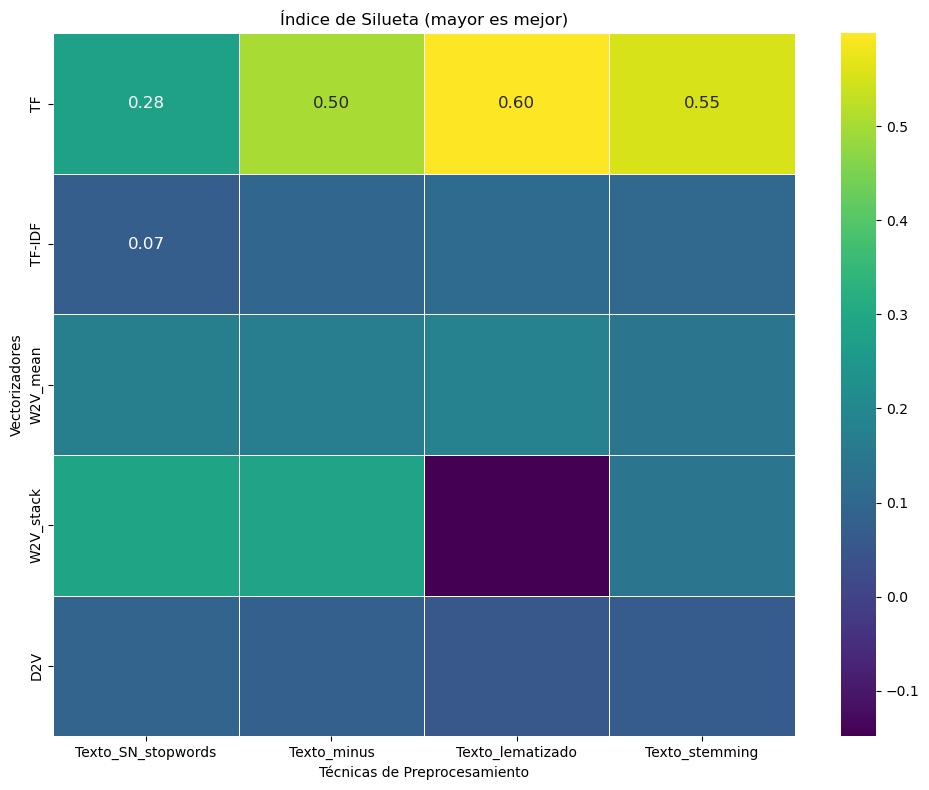

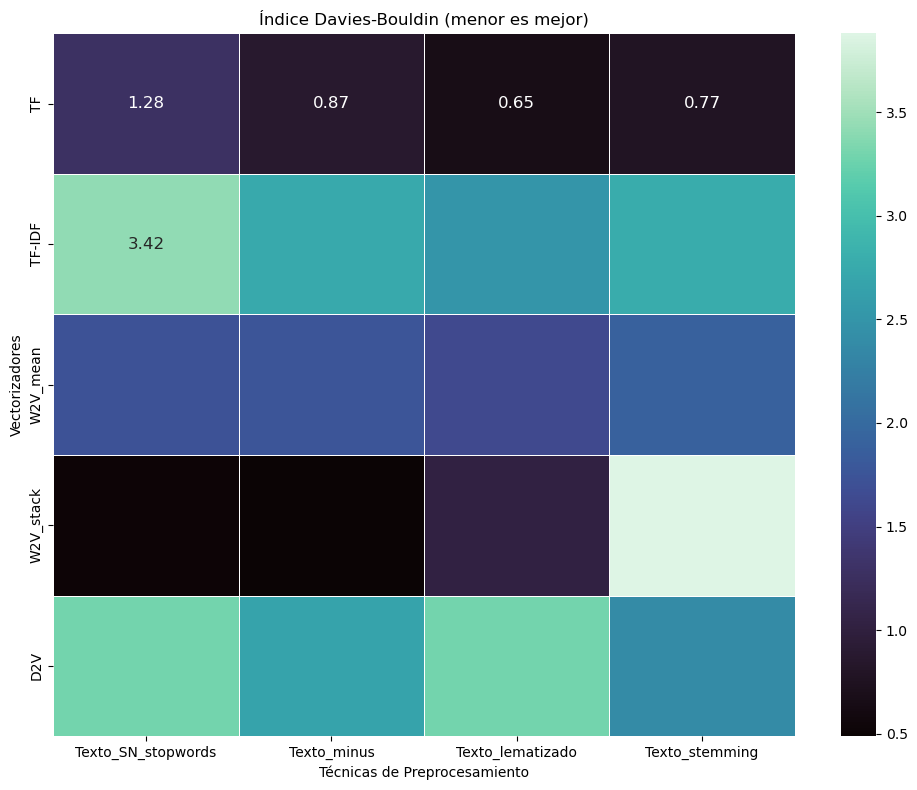

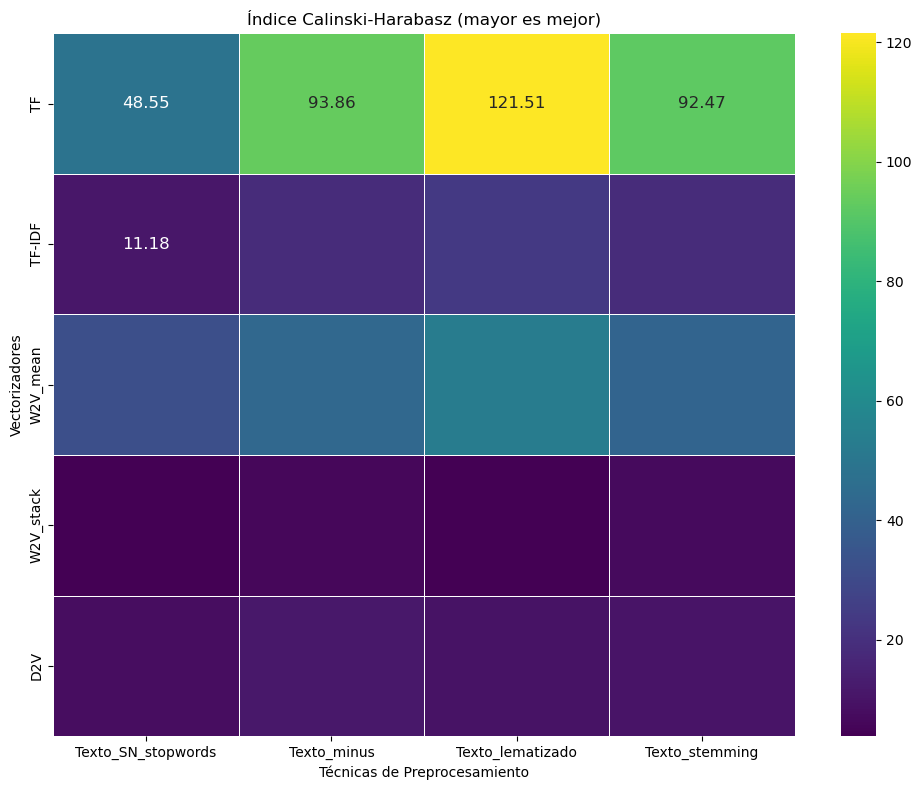

In [54]:
# Nombres de las filas y columnas
vectorizadores = ['TF', 'TF-IDF', 'W2V_mean', 'W2V_stack', 'D2V']
tecnicas_prepro = ['Texto_SN_stopwords', 'Texto_minus', 'Texto_lematizado', 'Texto_stemming']

# Crear DataFrames para los datos de ejemplo
df_silhouette = pd.DataFrame(silhouette_scores, index=vectorizadores, columns=tecnicas_prepro)
df_davies_bouldin = pd.DataFrame(davies_bouldin_scores, index=vectorizadores, columns=tecnicas_prepro)
df_calinski_harabasz = pd.DataFrame(calinski_harabasz_scores, index=vectorizadores, columns=tecnicas_prepro)

# Función para crear un mapa de calor
def plot_heatmap(df, title, higher_better=True):
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(df, annot=True,fmt=".2f", cmap='viridis' if higher_better else 'mako', linewidths=.5, annot_kws={"size": 12})
    plt.title(title)
    plt.xlabel("Técnicas de Preprocesamiento")
    plt.ylabel("Vectorizadores")
    plt.tight_layout()
    plt.show()

plot_heatmap(df_silhouette, "Índice de Silueta (mayor es mejor)")
plot_heatmap(df_davies_bouldin, "Índice Davies-Bouldin (menor es mejor)", higher_better=False)
plot_heatmap(df_calinski_harabasz, "Índice Calinski-Harabasz (mayor es mejor)")


In [55]:
import plotly.express as px
import pandas as pd
import numpy as np



# Función modificada para usar Plotly en lugar de Matplotlib y Seaborn
def plotly_heatmap(df, title, higher_better=True):
    color_scale = 'Viridis' if higher_better else 'thermal'
    fig = px.imshow(df,
                    labels=dict(x="Técnicas de Preprocesamiento", y="Vectorizadores", color="Score"),
                    x=df.columns,
                    y=df.index,
                    color_continuous_scale=color_scale,
                    title=title)
    # Añadir anotaciones de texto una por una con el valor correspondiente
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            fig.add_annotation(x=x, y=y, text=f"{df.iloc[y, x]:.2f}", showarrow=False, font=dict(color="white"))
    fig.update_xaxes(side="bottom")
    fig.show()

plotly_heatmap(df_silhouette, "Índice de Silueta (mayor es mejor)")
plotly_heatmap(df_davies_bouldin, "Índice Davies-Bouldin (menor es mejor)", higher_better=False)
plotly_heatmap(df_calinski_harabasz, "Índice Calinski-Harabasz (mayor es mejor)")


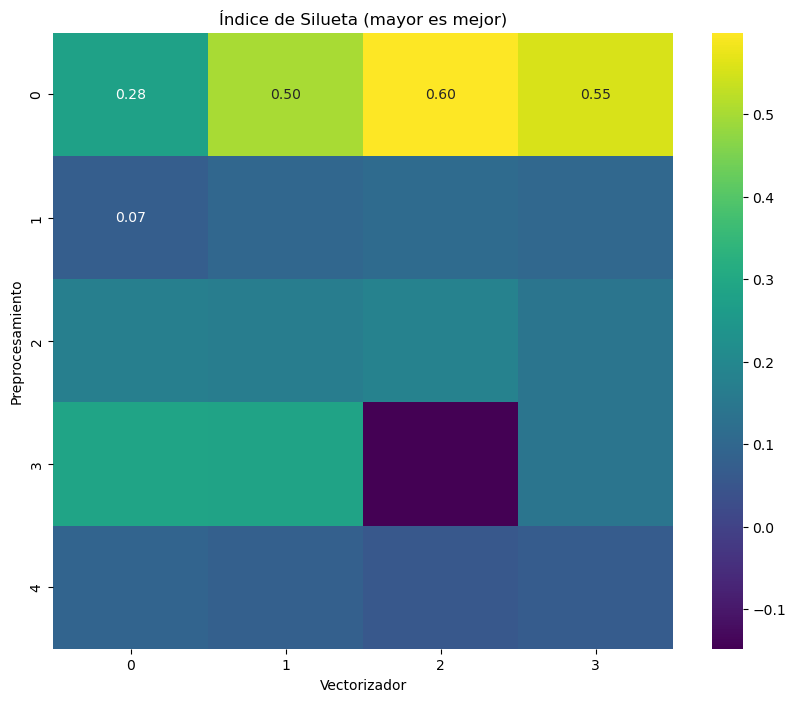

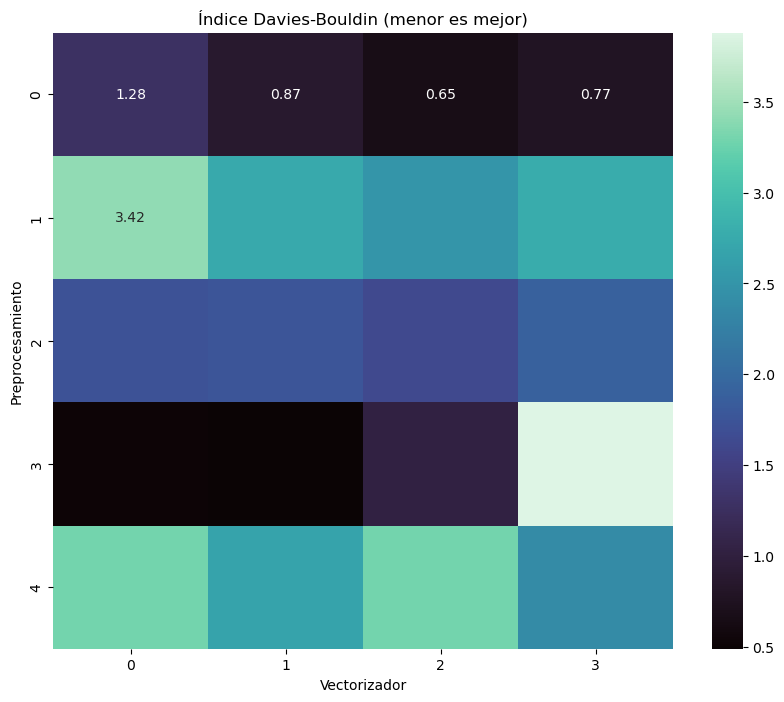

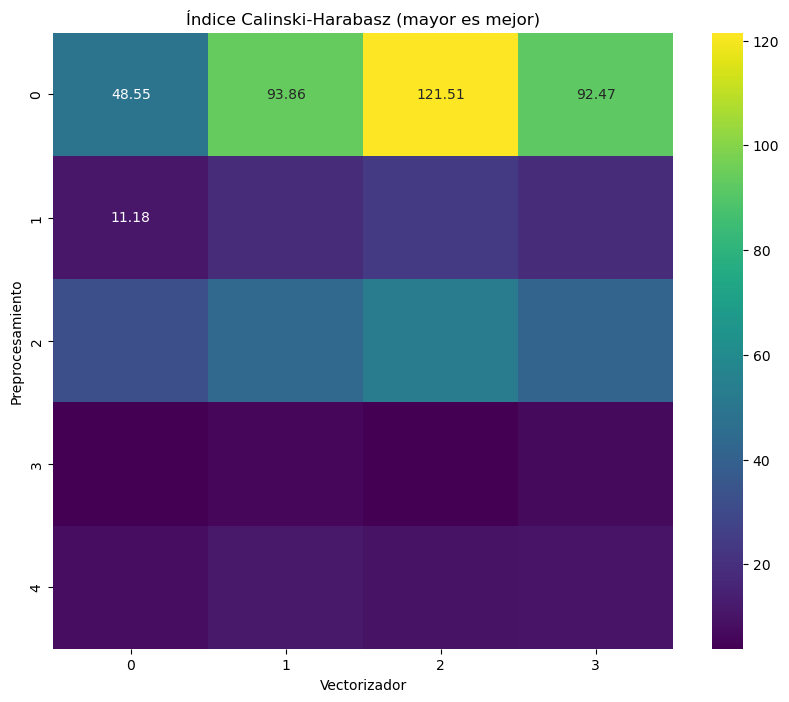

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que silhouette_scores, davies_bouldin_scores y calinski_harabasz_scores ya están calculados

# Función para crear un mapa de calor
def plot_heatmap(data, title, higher_better=True):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, annot=True, fmt=".2f", cmap='viridis' if higher_better else 'mako')
    plt.title(title)
    plt.xlabel("Vectorizador")
    plt.ylabel("Preprocesamiento")
    plt.show()

# Crear mapas de calor para cada métrica
plot_heatmap(silhouette_scores, "Índice de Silueta (mayor es mejor)")
plot_heatmap(davies_bouldin_scores, "Índice Davies-Bouldin (menor es mejor)", higher_better=False)
plot_heatmap(calinski_harabasz_scores, "Índice Calinski-Harabasz (mayor es mejor)")

# Borrador

## D2V

In [57]:
# Preprocesamiento y etiquetado de los documentos
etiquetado_datos = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df_grouped.iloc[:,3].values)]

In [58]:
# Configuración del modelo Doc2Vec
modelo = Doc2Vec(vector_size=30, 
                 window=2, 
                 min_count=1, 
                 workers=30, 
                 epochs=100)

In [59]:
# Construcción del vocabulario
modelo.build_vocab(etiquetado_datos)

In [60]:
# Entrenamiento del modelo
modelo.train(etiquetado_datos, total_examples=modelo.corpus_count, epochs=modelo.epochs)

In [61]:
# Obtener los vectores característicos para cada documento
vectores_caracteristicos = [modelo.infer_vector(word_tokenize(doc.lower())) for doc in df_grouped.iloc[:,3].values]

In [62]:
vectores_caracteristicos

[array([-0.2927856 , -1.3005358 ,  0.33260858, -1.0185251 , -0.7265616 ,
         3.9137444 , -3.6626985 , -1.3907107 ,  0.63276803,  3.4857285 ,
         1.495004  , -0.9042738 ,  0.70969456, -0.88780004, -1.1860776 ,
        -2.619113  ,  0.71433645,  1.200896  , -1.8518252 , -0.73154485,
        -1.5693469 , -5.7691994 , -0.3152265 ,  2.5201452 , -2.453133  ,
         1.3187392 , -2.46876   ,  0.1877524 ,  1.8009216 , -3.7810082 ],
       dtype=float32),
 array([ 3.6436791 ,  0.735706  , -0.36370987, -2.6063833 , -1.1862893 ,
         2.4236047 , -0.0529855 , -2.56371   , -3.0154328 ,  1.0374091 ,
         3.5303144 ,  2.9738076 ,  4.655432  , -2.0740566 , -1.5114408 ,
        -0.5128521 , -2.035978  , -3.3795838 , -3.870257  , -0.4056432 ,
         1.3925436 , -3.8072066 ,  2.6083162 , -1.9245428 ,  3.690909  ,
         4.777209  ,  1.2792438 ,  4.2691298 ,  3.1511483 ,  1.1066847 ],
       dtype=float32),
 array([-0.46365383,  1.2537135 ,  2.4979146 , -1.9852394 , -3.9021869 ,
   

# Pendientes
- Mejorar los datos de entrenamiento para W2V y Doc2Vec
- Continuar con las técnicas declustering
- Investigar sobre optimización de hiperparámetros (w2v, Itfidf, Doc2Vec)

Para entrenar tu modelo Doc2Vec con un corpus más grande en español, puedes recurrir a varias fuentes abiertas que ofrecen datos limpios y listos para usarse. Aquí te menciono algunas opciones:

1. **Wikipedia Dump**: Una de las formas más comunes de obtener un gran corpus es utilizar un volcado de Wikipedia. La ventaja es que los artículos de Wikipedia cubren una amplia gama de temas, lo que permite obtener un modelo bastante general. Puedes obtener el volcado en español desde [aquí](https://dumps.wikimedia.org/eswiki/).

2. **Common Crawl**: Este es un recurso que contiene datos de rastreo web y que incluye múltiples idiomas, incluido el español. Es un conjunto de datos muy grande y diverso que se actualiza regularmente. Puedes acceder a él [aquí](https://commoncrawl.org/).

3. **Corpus de la Academia Real Española (CORPES XXI)**: Este es un corpus equilibrado del español contemporáneo. No es de acceso abierto completo, pero podrías conseguir una licencia académica. Más información [aquí](http://www.rae.es/).

4. **Repositorios en GitHub**: Hay varios repositorios en GitHub que ofrecen conjuntos de datos en español para entrenamiento en NLP. Es posible que encuentres alguno que se ajuste a tus necesidades.

5. **OpenSubtitles**: Si estás interesado en un lenguaje más coloquial, puedes utilizar el conjunto de datos de OpenSubtitles, que contiene subtítulos de películas en varios idiomas, incluido el español. Se puede descargar desde [aquí](http://opus.nlpl.eu/OpenSubtitles.php).

6. **Otros conjuntos de datos académicos**: Sitios como [Kaggle](https://www.kaggle.com/datasets) a menudo tienen conjuntos de datos en español que podrían ser útiles para tus necesidades.

Para usar estos conjuntos de datos, tendrás que descargarlos y preprocesarlos para que se ajusten al formato que requiere el modelo Doc2Vec de Gensim. Este preprocesamiento puede incluir la limpieza de texto, la eliminación de etiquetas HTML, la tokenización, etc.

Una vez que tengas el conjunto de datos en el formato deseado, puedes seguir los mismos pasos que mencioné en el ejemplo de código anterior para entrenar tu modelo.

# Topic modeling